In [ ]:
!pip install tensorflow tensorflow_hub


In [ ]:
from google.colab import files

# This will prompt you to upload the zip file from your local machine
uploaded =files.upload()

Saving Dataset Brain Tumor.zip to Dataset Brain Tumor.zip


In [ ]:
import zipfile
import os

# Specify the name of the uploaded zip file
zip_file_name = 'Dataset Brain Tumor.zip'  # Change this if your zip file name is different

# Unzip the file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall('Dataset Brain Tumor')

# Verify the contents of the unzipped directory
os.listdir('Dataset Brain Tumor')

['Dataset Brain Tumor']

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation parameters
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.3,
    zoom_range=0.4,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)


# Load training data with augmentation
train_generator = datagen.flow_from_directory(
    '/content/Dataset Brain Tumor/Dataset Brain Tumor/Training Dataset',
    target_size=(240, 240),
    batch_size=32,
    class_mode='categorical'
)

# Load testing data without augmentation
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '/content/Dataset Brain Tumor/Dataset Brain Tumor/Testing Dataset',
    target_size=(240, 240),
    batch_size=32,
    class_mode='categorical'
)


Found 5708 images belonging to 4 classes.
Found 1273 images belonging to 4 classes.


In [ ]:
!pip install vit-keras tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.3.1 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
# Step 1: Install vit-keras and tensorflow-addons libraries
!pip install vit-keras tensorflow-addons

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model, Model
from vit_keras import vit
import tensorflow_addons as tfa

# Define data augmentation parameters
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load training data with augmentation
train_generator = datagen.flow_from_directory(
    '/content/Dataset Brain Tumor/Dataset Brain Tumor/Training Dataset',
    target_size=(224, 224),  # Change to 224x224
    batch_size=32,
    class_mode='categorical'
)

# Load testing data without augmentation
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '/content/Dataset Brain Tumor/Dataset Brain Tumor/Testing Dataset',
    target_size=(224, 224),  # Change to 224x224
    batch_size=32,
    class_mode='categorical'
)

# Load ViT model
vit_model = vit.vit_b32(
    image_size=224,
    pretrained=True,
    include_top=True,  # Ensure include_top is True
)

# Create a new model with ViT base
input_layer = Input(shape=(224, 224, 3))
vit_output = vit_model(input_layer)

# Use the ViT output for classification
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(vit_output)
x = Dropout(0.5)(x)
x = Dense(4, activation='softmax')(x)

# Create the final model
model = Model(inputs=input_layer, outputs=x)

# Compile the model with additional metrics
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             tfa.metrics.F1Score(num_classes=4, average='macro', name='f1_score'),
             tf.keras.metrics.AUC(name='auc')]
)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)

# Step 3: Evaluate the best model

# Load the best model based on validation accuracy
best_model = load_model('best_model.h5', custom_objects={'f1_score': tfa.metrics.F1Score(num_classes=4, average='macro')})

# Evaluate the performance of the best model on the test dataset
evaluation = best_model.evaluate(test_generator)
print(f"Test Loss: {evaluation[0]}")
print(f"Test Accuracy: {evaluation[1]}")
print(f"Test Precision: {evaluation[2]}")
print(f"Test Recall: {evaluation[3]}")
print(f"Test F1 Score: {evaluation[4]}")
print(f"Test AUC: {evaluation[5]}")
test_generator.reset()
predictions = best_model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Generate classification report
class_labels = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n", report)

# Calculate AUC Scores per class
y_true_bin = tf.keras.utils.to_categorical(y_true, num_classes=4)
auc_scores = roc_auc_score(y_true_bin, predictions, multi_class='ovo')
print(f"AUC Scores per class: {auc_scores}")

Found 5708 images belonging to 4 classes.
Found 1273 images belonging to 4 classes.
353253686/353253686 [==============================] - 8s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Epoch 1/30
179/179 [==============================] - ETA: 0s - loss: 1.5227 - accuracy: 0.8010 - precision: 0.8260 - recall: 0.7742 - f1_score: 0.7949 - auc: 0.9545

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


179/179 [==============================] - 162s 643ms/step - loss: 1.5227 - accuracy: 0.8010 - precision: 0.8260 - recall: 0.7742 - f1_score: 0.7949 - auc: 0.9545 - val_loss: 1.2289 - val_accuracy: 0.9018 - val_precision: 0.9133 - val_recall: 0.8932 - val_f1_score: 0.8942 - val_auc: 0.9885 - lr: 1.0000e-04
Epoch 2/30
179/179 [==============================] - 109s 608ms/step - loss: 1.2143 - accuracy: 0.9070 - precision: 0.9142 - recall: 0.9017 - f1_score: 0.9034 - auc: 0.9879 - val_loss: 1.1981 - val_accuracy: 0.9175 - val_precision: 0.9188 - val_recall: 0.9152 - val_f1_score: 0.9120 - val_auc: 0.9872 - lr: 1.0000e-04
Epoch 3/30
179/179 [==============================] - 114s 634ms/step - loss: 1.1072 - accuracy: 0.9306 - precision: 0.9351 - recall: 0.9266 - f1_score: 0.9279 - auc: 0.9930 - val_loss: 1.0749 - val_accuracy: 0.9332 - val_precision: 0.9345 - val_recall: 0.9309 - val_f1_score: 0.9297 - val_auc: 0.9949 - lr: 1.0000e-04
Epoch 4/30
179/179 [==============================] - 

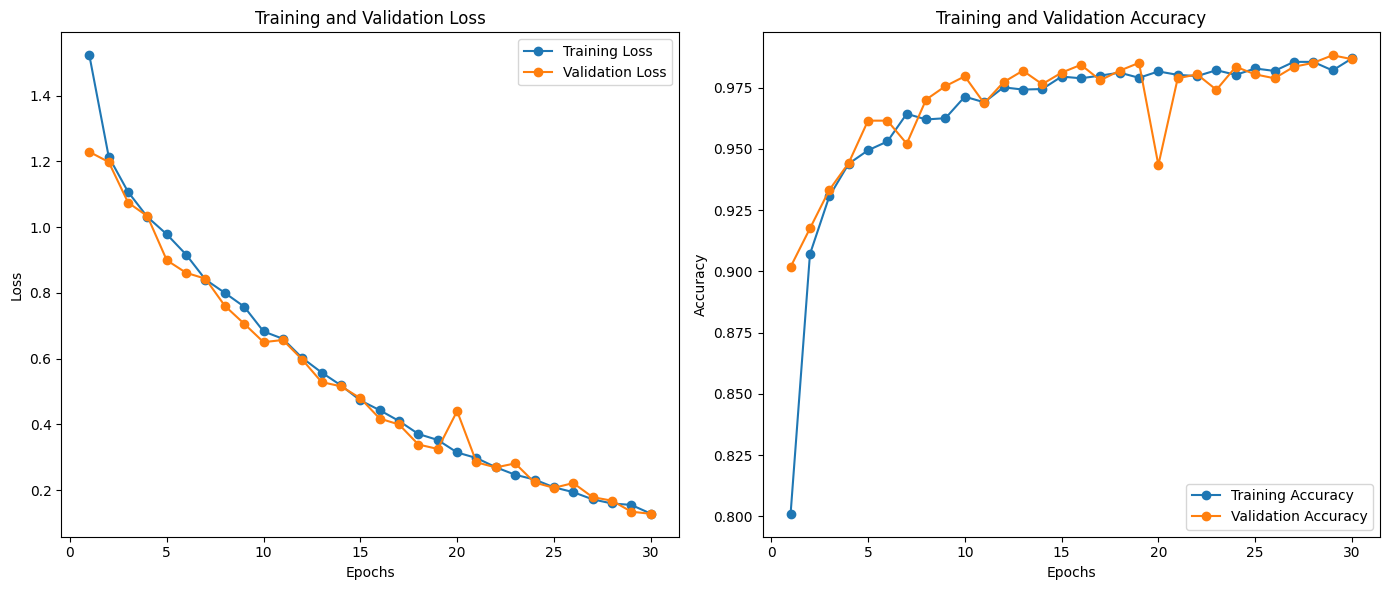

In [3]:
import matplotlib.pyplot as plt

# Metrics from your logs
epochs = list(range(1, 31))

# Training metrics
train_loss = [1.5227, 1.2143, 1.1072, 1.0308, 0.9783, 0.9164, 0.8405, 0.8000, 0.7580, 0.6828,
              0.6604, 0.6020, 0.5579, 0.5187, 0.4731, 0.4433, 0.4104, 0.3709, 0.3527, 0.3147,
              0.2978, 0.2697, 0.2469, 0.2324, 0.2088, 0.1940, 0.1722, 0.1596, 0.1552, 0.1288]
train_accuracy = [0.8010, 0.9070, 0.9306, 0.9439, 0.9494, 0.9530, 0.9643, 0.9620, 0.9625, 0.9713,
                   0.9690, 0.9751, 0.9742, 0.9744, 0.9795, 0.9788, 0.9799, 0.9811, 0.9790, 0.9816,
                   0.9802, 0.9797, 0.9821, 0.9802, 0.9828, 0.9818, 0.9855, 0.9855, 0.9820, 0.9869]

# Validation metrics
val_loss = [1.2289, 1.1981, 1.0749, 1.0332, 0.8993, 0.8611, 0.8431, 0.7606, 0.7061, 0.6502,
            0.6568, 0.5971, 0.5288, 0.5159, 0.4798, 0.4178, 0.3998, 0.3389, 0.3254, 0.4405,
            0.2847, 0.2692, 0.2815, 0.2234, 0.2071, 0.2217, 0.1788, 0.1681, 0.1346, 0.1282]
val_accuracy = [0.9018, 0.9175, 0.9332, 0.9442, 0.9615, 0.9615, 0.9521, 0.9701, 0.9756, 0.9796,
                 0.9686, 0.9772, 0.9819, 0.9764, 0.9811, 0.9843, 0.9780, 0.9819, 0.9851, 0.9434,
                 0.9788, 0.9804, 0.9741, 0.9835, 0.9804, 0.9788, 0.9835, 0.9851, 0.9882, 0.9866]

# Plot the graphs
plt.figure(figsize=(14, 6))

# Plot Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
